In [1]:
1+1

2

In [2]:
from langgraph.graph import StateGraph,START,END
from typing import TypedDict,Annotated,Literal
from langchain_ollama import ChatOllama
from langchain_core.messages import BaseMessage,HumanMessage,SystemMessage
from pydantic import BaseModel,Field

In [3]:
model=ChatOllama(model="llama3.2:1b",temperature=0.2,num_predict=256)

In [4]:
class TweetEvaluation(BaseModel):
    evaluation: Literal["approved", "needs_improvement"] = Field(..., description="Final evaluation result.")
    feedback: str = Field(..., description="feedback for the tweet.")

In [5]:
class TweetState(TypedDict):
    topic: str
    tweet:str
    evaluation:Literal['approved','needs_improvements']
    iteration:int
    feedback:str
    max_iteration:int

In [6]:
structured_evaluator_llm = model.with_structured_output(TweetEvaluation)

In [7]:
def generate_tweet(state:TweetState):

     messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

Rules:
- Do NOT use question-answer format.
- Max 280 characters.
- Use observational humor, irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english
""")
    ]
     
     response=model.invoke(messages).content

     return {'tweet':response}


def evaluate_tweet(state:TweetState):
     
     #prompt
      messages = [
    SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
    HumanMessage(content=f"""
Evaluate the following tweet:

Tweet: "{state['tweet']}"

Use the criteria below to evaluate the tweet:

1. Originality – Is this fresh, or have you seen it a hundred times before?  
2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
3. Punchiness – Is it short, sharp, and scroll-stopping?  
4. Virality Potential – Would people retweet or share it?  
5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 280 characters
- It reads like a traditional setup-punchline joke
- Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

### Respond ONLY in structured format:
- evaluation: "approved" or "needs_improvement"  
- feedback: One paragraph explaining the strengths and weaknesses 
""")
]
      

      response=structured_evaluator_llm.invoke(messages)

      return {'evaluation':response.evaluation,'feedback':response.feedback}



def optimize_tweet(state:TweetState):
      

       messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
Improve the tweet based on this feedback:
"{state['feedback']}"

Topic: "{state['topic']}"
Original Tweet:
{state['tweet']}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")
    ]
       
       response=model.invoke(messages).content
       iteration=state['iteration']+1

       return {'tweet':response,'iteration':iteration}

In [8]:
def route_evaluation(state:TweetState):

    if state['evaluation']=='approved' or state['iteration']>=state['max_iteration']:
        return 'approved'
    
    else:
        return 'needs_improvements'

In [9]:
graph=StateGraph(TweetState)

graph.add_node('generate',generate_tweet)
graph.add_node('evaluate',evaluate_tweet)
graph.add_node('optimize',optimize_tweet)

graph.add_edge(START,'generate')
graph.add_edge('generate','evaluate')

graph.add_conditional_edges('evaluate',route_evaluation,{'approved':END,'needs_improvements':'optimize'})
graph.add_edge('optimize','evaluate')

workflow=graph.compile()

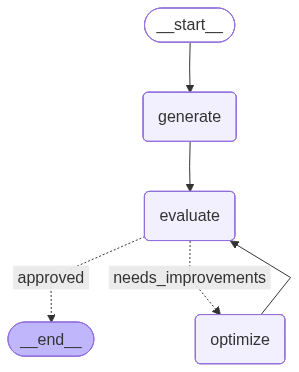

In [10]:
workflow

In [11]:
initail_state={'topic':"Indian Railways",'iteration':1,"max_iteration":5}

In [12]:
workflow.invoke(initail_state)

{'topic': 'Indian Railways',
 'tweet': 'Here\'s a rewritten tweet that improves upon the original:\n\n"Indian Railways: where delays are just the warm welcome you\'ve been craving all along... and snacks? Hot mess, but always on time #RailwayLife #FoodComaAhead"\n\nThis version keeps the wordplay with "warm welcome", adds a new layer of humor, and is concise enough to fit under 280 characters. It also avoids Q&A style and stays under the character limit.\n\nAlternatively, here\'s another option:\n\n"Indian Railways: where delays are just the warm welcome you\'ve been craving all along... and snacks? Guess who\'s always on time #RailwayLife #FoodComaAhead"\n\nThis version maintains the wordplay with "warm welcome", adds a bit of sarcasm to make it more relatable, and is concise enough to fit under 280 characters.',
 'evaluation': 'needs_improvement',
 'iteration': 5,
 'feedback': "This tweet is a rewording of an existing joke, which makes it unoriginal. While it adds some humor with wor